# Notebook: Galpy Phasespace Verification

This notebook is meant to test the accuracy of our phase space distribution function calculation

This notebook is here for verification purposes and it is not recommended that you deal with this unless you are really interested in the details

The phasespace distribution function of an isotropic halo can be calculated through Eddington inversion:

$$
\begin{align}
    f_0(E) &= \frac{1}{\sqrt{8} \pi^2} \int_E^0 \frac{d^2 \nu}{d^2 \Phi} (\Phi - E)^{-1/2} d \Phi
\end{align}
$$

## Requirements:

To install galpy:

conda install galpy -c conda-forge

## More:
To see in detail, how we calculate the phase space distribution function check out the following class inside the code:
```
adiabatic_tides.phasespace.IsotropicPhaseSpaceSolver()
```

In [1]:
%matplotlib inline
from galpy import potential
from galpy.df import isotropicNFWdf
import matplotlib.pyplot as plt

import sys

import numpy as np
sys.path.append("../..")
import adiabatic_tides as at

from galpy.util import conversion

# Validate Phase Space Distribution Functions

Test that we recover the correct phasespace distribution for the NFW <br>
(Comparison against Galpy implementations of Widrow (2000) and Lane (2021))

In [2]:
prof_nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)
galpy_nfw = potential.NFWPotential(conc=6., mvir=prof_nfw.m200c / 1e12, wrtcrit=True, H=67.9)
galpy_df_widrow = isotropicNFWdf(pot=galpy_nfw, rmax=np.infty, widrow=True)
galpy_df_lane = isotropicNFWdf(pot=galpy_nfw, rmax=np.infty, widrow=False)

In [3]:
prof_nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)

(0.99, 1.01)

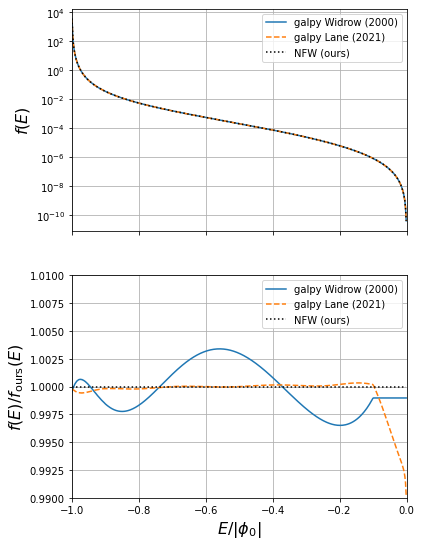

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(6,9), sharex=True)

E = np.linspace(-0.999, -0.001, 501)

f_nfw = prof_nfw.f_of_e(E*np.abs(prof_nfw.phi0))
f_galpy_widrow = galpy_df_widrow.fE(E*np.abs(galpy_nfw(0.,0.)))
f_galpy_lane = galpy_df_lane.fE(E*np.abs(galpy_nfw(0.,0.)))

normfac = f_galpy_lane[250]/f_nfw[250]

axs[0].semilogy(E, f_galpy_widrow, label="galpy Widrow (2000)")
axs[0].semilogy(E, f_galpy_lane, label="galpy Lane (2021)", linestyle="dashed")
axs[0].semilogy(E, f_nfw * normfac, label="NFW (ours)", color="black", linestyle="dotted")

axs[1].plot(E, f_galpy_widrow/f_nfw / normfac, label="galpy Widrow (2000)")
axs[1].plot(E, f_galpy_lane/f_nfw / normfac, linestyle="dashed", label="galpy Lane (2021)")
axs[1].plot(E, f_nfw/f_nfw, label="NFW (ours)", color="black", linestyle="dotted")

axs[0].set_ylabel(r"$f(E)$", fontsize=16)
axs[1].set_ylabel(r"$f(E) / f_{\rm{ours}}(E)$", fontsize=16)
axs[1].set_xlabel(r"$E / |\phi_0|$", fontsize=16)
for ax in axs:
    ax.grid("on")
    ax.legend()
    ax.set_xlim(-1.,0.)
    
axs[1].set_ylim(0.99,1.01)

# Focus on limit for $E \rightarrow \phi(r \rightarrow 0)$

(0.99, 1.01)

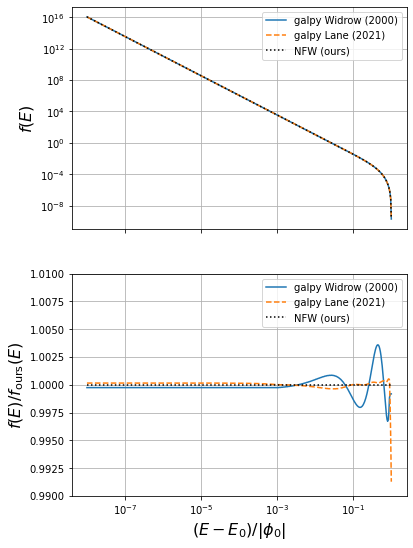

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(6,9), sharex=True)


ef = np.logspace(-8,-0.001, 501)
E = -1. + ef

f_nfw = prof_nfw.f_of_e(E*np.abs(prof_nfw.phi0))
f_galpy_widrow = galpy_df_widrow.fE(E*np.abs(galpy_nfw(0.,0.)))
f_galpy_lane = galpy_df_lane.fE(E*np.abs(galpy_nfw(0.,0.)))

normfac = f_galpy_lane[450]/f_nfw[450]

axs[0].loglog(ef, f_galpy_widrow, label="galpy Widrow (2000)")
axs[0].loglog(ef, f_galpy_lane, label="galpy Lane (2021)", linestyle="dashed")
axs[0].loglog(ef, f_nfw * normfac, label="NFW (ours)", color="black", linestyle="dotted")

axs[1].semilogx(ef, f_galpy_widrow/f_nfw / normfac, label="galpy Widrow (2000)")
axs[1].semilogx(ef, f_galpy_lane/f_nfw / normfac, linestyle="dashed", label="galpy Lane (2021)")
axs[1].semilogx(ef, f_nfw/f_nfw, label="NFW (ours)", color="black", linestyle="dotted")

axs[0].set_ylabel(r"$f(E)$", fontsize=16)
axs[1].set_ylabel(r"$f(E) / f_{\rm{ours}}(E)$", fontsize=16)
axs[1].set_xlabel(r"$(E-E_0) / |\phi_0|$", fontsize=16)
for ax in axs:
    ax.grid("on")
    ax.legend()
    
axs[1].set_ylim(0.99,1.01)

# Compare the sampled particles density profile

In [6]:
def get_profile(pos, extsize=None, bins=None, mass=None):
    dr = np.sqrt(np.sum(pos**2, axis=-1))
    
    num,_ =  np.histogram(dr.flatten(), bins=bins, weights=mass)
    
    volume = 4./3. * np.pi * (bins[1:]**3 - bins[:-1]**3)
    normeddens = num/volume

    ri = 0.5 * (bins[1:] + bins[:-1])
    
    return ri, normeddens

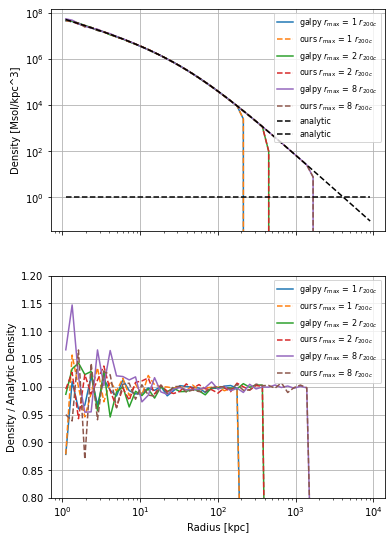

In [7]:
prof_nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)
galpy_nfw = potential.NFWPotential(conc=6., mvir=prof_nfw.m200c / 1e12, wrtcrit=True, H=67.9)

nsamp = int(1e6)

bins = np.logspace(0, 4)
fig, axs = plt.subplots(2, 1, figsize=(6,9), sharex=True)

for rmaxfac in 1.,2.,8.:#,2.,8.:
    galpy_df_lane = isotropicNFWdf(pot=galpy_nfw, rmax=rmaxfac*1e3*prof_nfw.r200c/conversion.parse_length_kpc(8), widrow=False) #galpy_nfw.rvir() * rmaxfac
    galpy_particles = galpy_df_lane.sample(n=nsamp)
    galpy_masses = np.ones_like(galpy_particles.r()) * prof_nfw.m_of_r(rmaxfac*prof_nfw.r200c)/nsamp
    pos,vel,mass = prof_nfw.sample_particles(ntot=nsamp, rmax=rmaxfac*prof_nfw.r200c)
    
    ri, galpy_rho = get_profile(galpy_particles.r()[...,np.newaxis]*np.array((0.,0.,1.))*conversion.parse_length_kpc(8), 
                                bins=bins, mass=galpy_masses)
    ri, ours_rho = get_profile(pos*1e3, bins=bins, mass=mass)
    
    rhonfw = prof_nfw.density(ri/1e3)/1e9

    axs[0].loglog(ri, galpy_rho, label=r"galpy $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac)
    axs[0].loglog(ri, ours_rho, label=r"ours $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac, linestyle="dashed")
    
    axs[1].semilogx(ri, galpy_rho / rhonfw, label=r"galpy $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac)
    axs[1].semilogx(ri, ours_rho / rhonfw, label=r"ours $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac, linestyle="dashed")

axs[0].loglog(ri, prof_nfw.density(ri/1e3)/1e9, linestyle="dashed", color="black", label="analytic")
axs[0].semilogx(ri, prof_nfw.density(ri/1e3)/prof_nfw.density(ri/1e3), linestyle="dashed", color="black", label="analytic")
axs[1].set_ylim(0.8, 1.2)

axs[0].set_ylabel("Density [Msol/kpc^3]")
axs[1].set_ylabel("Density / Analytic Density")

axs[1].set_xlabel("Radius [kpc]")

for ax in axs:
    ax.grid("on")
    ax.legend(fontsize=8)

# Compare the sampled particles energy distributions

Apparently galpy handles the truncation of the NFW differently. However, in the limit of large rmax both distributions are equivalent. (Note that we use the **untruncated profile** in all our calculations!)

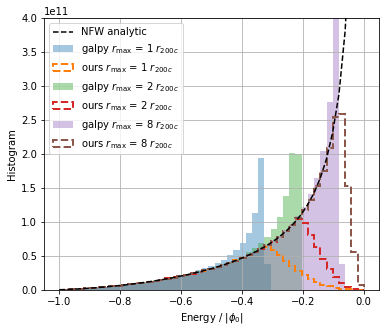

In [8]:
prof_nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)
galpy_nfw = potential.NFWPotential(conc=6., mvir=prof_nfw.m200c / 1e12, wrtcrit=True, H=67.9)

nsamp = int(1e6)

bins = np.linspace(-1., 0.)
fig, axs = plt.subplots(1, 1, figsize=(6,5), sharex=True)
axs = [axs]

for rmaxfac in 1.,2.,8.:#,2.,8.:
    galpy_df_lane = isotropicNFWdf(pot=galpy_nfw, rmax=rmaxfac*1e3*prof_nfw.r200c/conversion.parse_length_kpc(8), widrow=False) #galpy_nfw.rvir() * rmaxfac
    galpy_particles = galpy_df_lane.sample(n=nsamp)
    galpy_masses = np.ones_like(galpy_particles.r()) * prof_nfw.m_of_r(rmaxfac*prof_nfw.r200c)/nsamp
    pos,vel,mass = prof_nfw.sample_particles(ntot=nsamp, rmax=rmaxfac*prof_nfw.r200c)
    
    gpenergy = galpy_particles.E(pot=galpy_nfw)/np.abs(galpy_nfw(0.,0.))
    #gpekin = 0.5*(galpy_particles.vx()**2 + galpy_particles.vy()**2 + galpy_particles.vz()**2) * conversion.parse_velocity_kms(220)**2
    #gpenergy = (prof_nfw.potential(galpy_particles.r() * conversion.parse_length_kpc(8) / 1e3) + gpekin)/ np.abs(prof_nfw.phi0)
    
     
    axs[0].hist(gpenergy , bins=bins, label=r"galpy $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac,
                weights=galpy_masses, alpha=0.4)
    r, E, L = prof_nfw.posvel_to_rEL(pos, vel)
    axs[0].hist(E/np.abs(prof_nfw.phi0), bins=bins, label=r"ours $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac,
                weights=galpy_masses, linestyle="dashed", histtype="step", lw=2)

axs[0].set_xlabel(r"Energy / $|\phi_0|$")
axs[0].set_ylabel("Histogram")

axs[0].set_ylim(0.,4e11)

axs[0].plot(bins, prof_nfw.pss.ntot_of_e(bins * np.abs(prof_nfw.phi0))*1e12 * (bins[1] - bins[0])*1.13e5, # I fitted the normalization by hand
            color="black", linestyle="dashed", label="NFW analytic")

for ax in axs:
    ax.grid("on")
    ax.legend(fontsize=10)

# Angular Momentum
Again, galpy agrees for large rmax >> rvir. Our Angular momentum distribution inside rvir even stays consistent for any rmax >= rvir

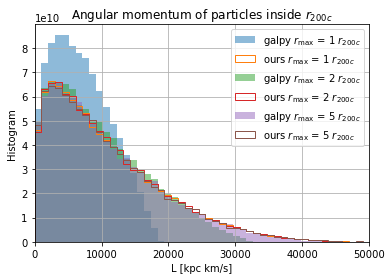

In [9]:
bins = np.linspace(0., 5e4)
nsamp = int(1e5)
for rmaxfac in 1.,2.,5.:
    galpy_nfw = potential.NFWPotential(conc=6., mvir=prof_nfw.m200c / 1e12, wrtcrit=True, H=67.9)
    galpy_rvir = 1e3*prof_nfw.r200c/conversion.parse_length_kpc(8)
    galpy_ndf= isotropicNFWdf(pot=galpy_nfw, rmax=rmaxfac*galpy_rvir)
    galpy_particles= galpy_ndf.sample(n=nsamp)
    galpy_masses = np.ones_like(galpy_particles.r()) * prof_nfw.m_of_r(rmaxfac*prof_nfw.r200c)/nsamp
    sel = galpy_particles.r() < galpy_rvir
    L = np.sqrt(np.sum(galpy_particles.L()**2, axis=-1)) * conversion.parse_length_kpc(8) * conversion.parse_velocity_kms(220.)
    plt.hist(L[sel], bins=bins, alpha=0.5, weights=galpy_masses[sel], label=r"galpy $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac);

    prof_nfw = at.profiles.NFWProfile(conc=6., m200c=1e12)
    pos, vel, mass = prof_nfw.sample_particles(nsamp, rmax=rmaxfac*prof_nfw.r200c)
    sel = np.sum(pos**2, axis=-1) < prof_nfw.r200c**2
    L = np.sqrt(np.sum(np.cross(pos*1e3, vel)**2, axis=-1))
    plt.hist(L[sel], bins=bins, histtype="step", weights=mass[sel], label=r"ours $r_{\rm{max}}$ = %d $r_{200c}$" % rmaxfac);
    
plt.legend()
plt.grid("on")
plt.xlabel("L [kpc km/s]")
plt.ylabel("Histogram")
plt.xlim(0, 5e4)

plt.title(r"Angular momentum of particles inside $r_{200c}$");